<a href="https://colab.research.google.com/github/pmeising/ML-tensorflow-23/blob/main/BaselineModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Assuming 'data_dir' is a path to the folder containing class subfolders
data_dir = "/content/drive/MyDrive/Phytoplankton_true/labeled_20201020"

# 2. Split the Data into train, validation, and test sets
# Get all image paths and their corresponding labels
image_paths = []
labels = []
for class_dir in os.listdir(data_dir):
    class_dir_path = os.path.join(data_dir, class_dir)
    if os.path.isdir(class_dir_path):
        for image in os.listdir(class_dir_path):
            image_paths.append(os.path.join(class_dir_path, image))
            labels.append(class_dir)

# Convert labels to numerical format
labels = np.array(labels)
label_to_index = dict((name, index) for index, name in enumerate(np.unique(labels)))
labels = np.array([label_to_index[label] for label in labels])

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.22, random_state=42) # 0.22 * 0.9 ≈ 0.2

# 3. Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 4. Load Data in Batches
def data_generator(image_paths, labels, batch_size, datagen):
    while True:
        for start in range(0, len(image_paths), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(image_paths))
            for img_path, label in zip(image_paths[start:end], labels[start:end]):
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
                img = tf.keras.preprocessing.image.img_to_array(img)
                x_batch.append(img)
                y_batch.append(label)
            x_batch = np.array(x_batch)
            y_batch = tf.keras.utils.to_categorical(y_batch, num_classes=50)
            yield datagen.flow(x_batch, y_batch, batch_size=batch_size).next()

batch_size = 64
train_generator = data_generator(X_train, y_train, batch_size, train_datagen)
val_generator = data_generator(X_val, y_val, batch_size, val_datagen)
test_generator = data_generator(X_test, y_test, batch_size, test_datagen)

# Function to print data format
def print_data_format(generator):
    x, y = next(generator)
    print(f'Image batch shape: {x.shape}')
    print(f'Label batch shape: {y.shape}')

# Print the format of a batch of training data
print_data_format(train_generator)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation

model = Sequential([
    Conv2D(32, (3, 3), input_shape=(128, 128, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64),
    Activation('relu'),
    Dense(50),
    Activation('softmax')
])

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 activation_8 (Activation)   (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 activation_9 (Activation)   (None, 61, 61, 64)        0         
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                 

In [8]:
# Set your training parameters
epochs = 2  # Number of epochs to train for

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,  # Number of steps per epoch
    epochs=epochs,                              # Number of epochs
    validation_data=val_generator,
    validation_steps=len(X_val) // batch_size   # Number of validation steps
)


Epoch 1/2
115/115 [==============================] - 2981s 26s/step - loss: 3.6231 - accuracy: 0.1645 - val_loss: 3.3213 - val_accuracy: 0.2554
Epoch 2/2
115/115 [==============================] - 223s 2s/step - loss: 3.3600 - accuracy: 0.2333 - val_loss: 3.1872 - val_accuracy: 0.2554


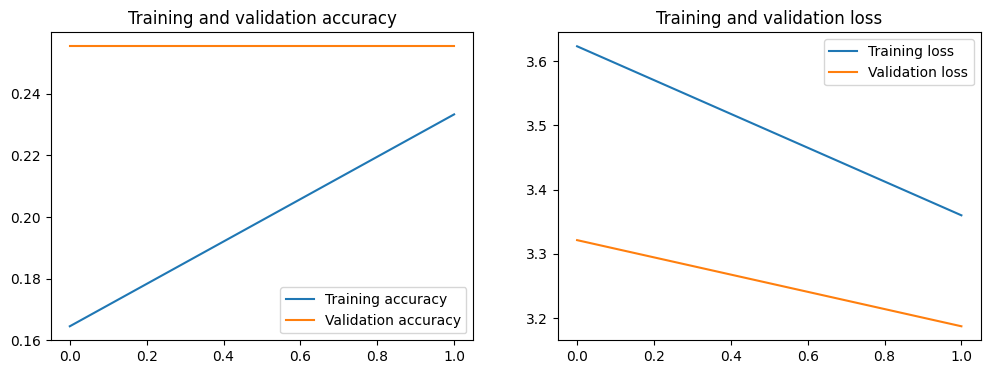

In [15]:
import matplotlib.pyplot as plt

# Generate plots for data visualization
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_training_history(history)